In [59]:
import pandas as pd

import os

import seaborn as sns


import matplotlib.pyplot as plt

def add_company_to_reviews(reviews_csv, companies_csv, html_folder, output_csv):
    reviews_df = pd.read_csv(reviews_csv)
    companies_df = pd.read_csv(companies_csv)
    html_files = os.listdir(html_folder)
    file_to_company = {
        os.path.splitext(file)[0].split('_')[0]: file
        for file in html_files
    }
    reviews_df['company'] = reviews_df['review_title'].apply(
        lambda x: file_to_company.get(x.split('_')[0], None) if isinstance(x, str) else None
    )
    final_df = reviews_df.merge(companies_df, left_on="company", right_on="c_site", how="left")
    final_df.to_csv(output_csv, index=False)
    print(f"Updated CSV saved to {output_csv}")






In [63]:
compa = pd.read_csv('trustpilot_companies.csv')

In [65]:
compa.isna().sum()

c_site               0
c_total_reviews      0
c_trust_score        0
c_location         267
dtype: int64

In [60]:
add_company_to_reviews(
     reviews_csv="trustpilot_reviews.csv",
     companies_csv="trustpilot_companies.csv",
     html_folder="raw_html",
     output_csv="trustpilot_reviews_with_companies.csv"
 )

Updated CSV saved to trustpilot_reviews_with_companies.csv


In [61]:
df = pd.read_csv('trustpilot_reviews_with_companies.csv')
df['date_experience'] = pd.to_datetime(df['date_experience'])
df.head()

,review_title,cust_name,cust_location,cust_reviews,cust_rating,cust_review_text,seller_response,date_experience,company,c_site,c_total_reviews,c_trust_score,c_location
0,PERFECTION,Ellen Feibel,US,3,5,First: you had the books I wanted for a gift t...,False,2024-12-14,NaN,NaN,NaN,NaN,NaN
1,Good book buying experience,Randy,US,2,5,Great communication about my order. Books arri...,False,2024-12-14,NaN,NaN,NaN,NaN,NaN
2,I appreciate the selection and the…,Nana,US,3,5,I appreciate the selection and the prices of t...,False,2024-12-13,NaN,NaN,NaN,NaN,NaN
3,The books arrived in a very timely…,customer,US,1,5,The books arrived in a very timely fashion and...,False,2024-12-14,NaN,NaN,NaN,NaN,NaN
4,"Quick delivery, fab products",customer,GB,8,5,Beautiful books delivered extremely quickly co...,False,2024-12-16,NaN,NaN,NaN,NaN,NaN


In [66]:
df.isna().sum()

review_title             2
cust_name               43
cust_location           12
cust_reviews             0
cust_rating              0
cust_review_text         0
seller_response          0
date_experience          0
company             140124
c_site              140124
c_total_reviews     140124
c_trust_score       140124
c_location          140124
dtype: int64

In [62]:
df.columns

Index(['review_title', 'cust_name', 'cust_location', 'cust_reviews',
       'cust_rating', 'cust_review_text', 'seller_response', 'date_experience',
       'company', 'c_site', 'c_total_reviews', 'c_trust_score', 'c_location'],
      dtype='object')

In [56]:
mask_duplicates = df.duplicated()
df[mask_duplicates]





,review_title,cust_name,cust_location,cust_reviews,cust_rating,cust_review_text,seller_response,date_experience
3611,Jaimie Holtman was very helpful in…,Steve M.,US,5,5,Jaimie Holtman was very helpful in helping me ...,True,2024-12-11
12577,It took to long to receive it.,Didimo Martinez,US,2,2,"Date of experience: July 22, 2024",True,2024-07-22
46651,Thanks BlueFiks for installing my…,Marlon,US,1,5,Thanks BlueFiks for installing my gazebo. You ...,False,2024-04-07
60432,Wall Decal World...second to none!!!,Allen Romano,US,3,5,The quality of the products at Wall Decal Worl...,True,2023-11-01
63920,Was told that I was renewing what I…,Lisa,US,3,1,Was told that I was renewing what I already ha...,True,2024-11-15
66534,Thank you,María José,PE,4,5,Thank you! I managed to remember key points th...,False,2024-11-21
66535,Thank you,María José,PE,4,5,Thank you! I managed to remember key points th...,False,2024-11-21
68280,Best of the best! Won products with fast shipping,Kelly,US,6,5,Wonderful products with fast shipping? great p...,False,2024-06-25
68281,Best of the best! Won products with fast shipping,Kelly,US,6,5,Wonderful products with fast shipping? great p...,False,2024-06-25
76582,I had a fantastic experience working…,Meet V Chaudhari,IN,3,5,I had a fantastic experience working with Aman...,False,2024-11-30


In [51]:
df['cust_location'].value_counts()

cust_location
US    122718
GB      4796
CA      3058
AU      1046
DE       736
       ...  
UM         1
FJ         1
SN         1
BL         1
NC         1
Name: count, Length: 199, dtype: int64

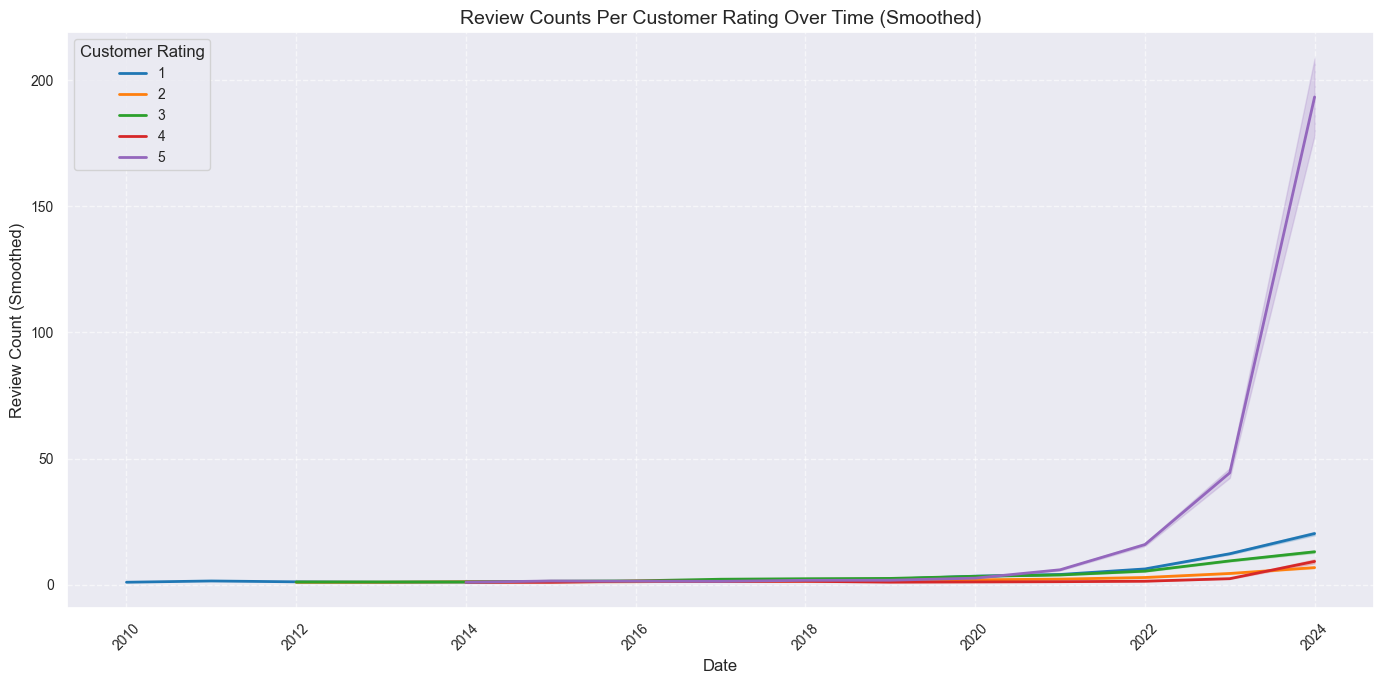

In [34]:
review_counts = df.groupby(['date_experience', 'cust_rating']).size().reset_index(name='review_count')


review_counts['date_experience'] = review_counts['date_experience'].dt.to_period('Y').dt.to_timestamp()


review_counts['review_count_smoothed'] = review_counts.groupby('cust_rating')['review_count'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count_smoothed',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)


plt.grid(True, linestyle='--', alpha=0.6)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count (Smoothed)', fontsize=12)
plt.title('Review Counts Per Customer Rating Over Time (Smoothed)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

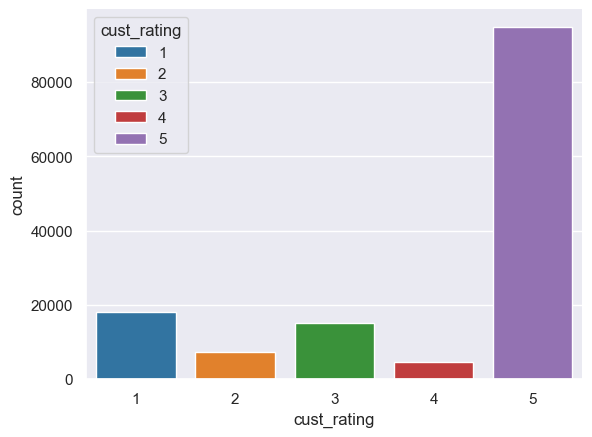

In [35]:
sns.countplot(x='cust_rating', data=df, hue='cust_rating', palette='tab10')
sns.despine()
plt.show()

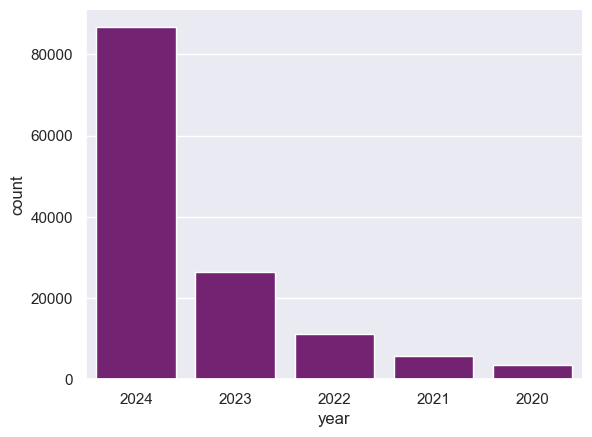

In [33]:
df['year'] = pd.to_datetime(df['date_experience']).dt.year
top_5 = df['year'].value_counts().sort_values(ascending=False).head()
df_top_5 = df[df['year'].isin(top_5.index)]
sns.countplot(x='year', data=df_top_5, order=top_5.index)
sns.despine()

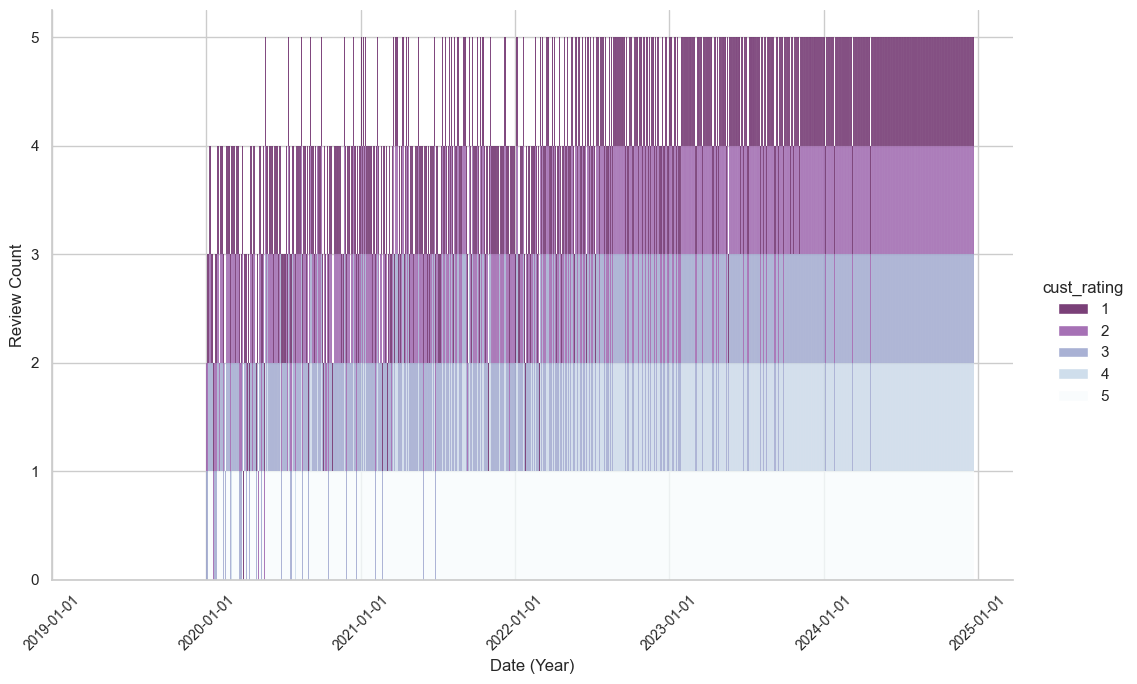

In [43]:
mask = df['year'].isin(top_5.index)

df.loc[mask, 'date_only'] = df.loc[mask, 'date_experience'].dt.date

df_line = df[mask].groupby(['date_only', 'cust_rating']).size().reset_index(name='count')
sns.set_theme(style="whitegrid", palette="muted")

# Use displot with hue
displot = sns.displot(
    data=df_line,
    x='date_only',
    hue='cust_rating',
    kind='hist',
    palette='BuPu_r',
    height=7,
    aspect=1.5,
    multiple='stack',  # Stacks the histogram for clarity
    bins=50  # Adjust the number of bins for better granularity
)

# Enhance the plot
displot.set_axis_labels("Date (Year)", "Review Count", fontsize=12)
displot.set_titles("Review Counts Per Customer Rating Over Time")
displot.set_xticklabels(rotation=45, fontsize=10)
displot.tight_layout()

plt.show()

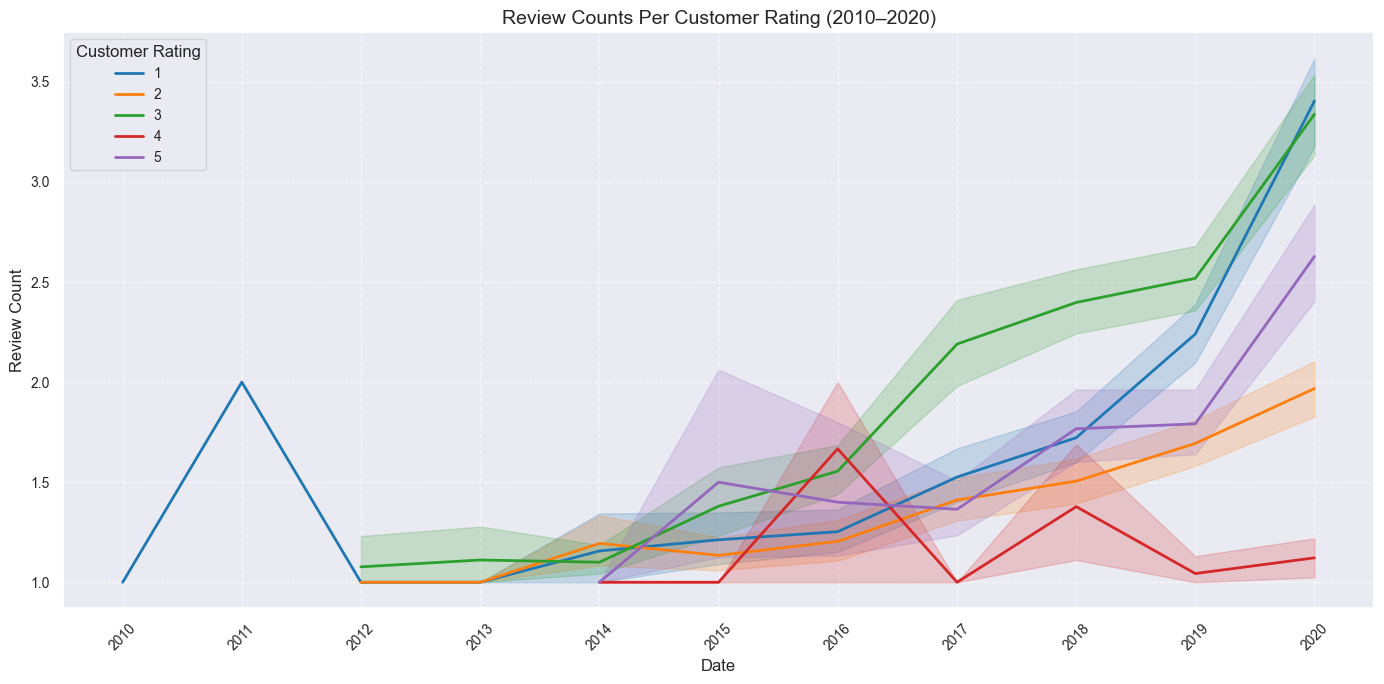

In [21]:
review_counts = review_counts[
    (review_counts['date_experience'] >= '2010-01-01') & (review_counts['date_experience'] <= '2020-12-31')
]


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)


plt.grid(True, linestyle='--', alpha=0.6)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Counts Per Customer Rating (2010–2020)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()